In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

d:\Project\AI\LangGraph\Lanchain_and_Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
openai_model=ChatOpenAI(model="gpt-3.5-turbo")

In [4]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFxipew0XvJsoxCqTIwrkfVvPgs3R', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ae67354c-98a7-4874-9454-63e185e083f6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [7]:
state={"num1":1, "num2":2}

In [8]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [9]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [10]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [11]:
model_with_tool=openai_model.bind_tools([transfer_to_multiplication_expert])

In [12]:
ai_message=model_with_tool.invoke("hi how are you?")

In [13]:
ai_message.tool_calls

[]

In [14]:
ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [15]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_4ldU1EY4hfs7ZwS79ErrZgb1',
  'type': 'tool_call'},
 {'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_iirqUTdVVwTSXj1YySVJ6NBQ',
  'type': 'tool_call'}]

In [17]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [18]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [19]:
graph=StateGraph(MessagesState)

In [20]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [21]:
graph.add_edge(START, "additional_expert")

In [22]:
app=graph.compile()

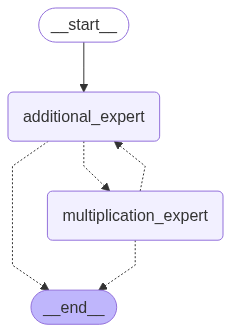

In [23]:
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='d7f3c6eb-8994-45aa-94c9-3550b0e94ff0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VRUWMmfece78Jtny7FUlZTCn', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFy6qpuKuQ5Fe0FUFCS1LnarYwf6u', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b2ed2d03-4a3e-4398-8af9-4962d60511fa-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}

In [25]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [26]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_386JHVaEyX3YXz0UelXWp5Gi)
 Call ID: call_386JHVaEyX3YXz0UelXWp5Gi
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================

I have calculated the result and it is 96.




In [27]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [28]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [29]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [30]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [31]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

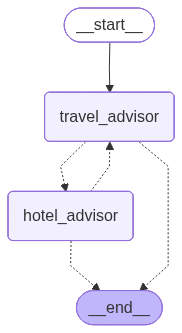

In [32]:
app = graph_builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [35]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Sri Lanka. Can you guide me on travel options and suggest the best hotel?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Sri Lanka. Can you guide me on travel options and suggest the best hotel?', additional_kwargs={}, response_metadata={}, id='bf78ef25-5693-4168-9c97-3cdde13148ec'),
  AIMessage(content='To assist you with hotel recommendations for your trip to California, I will contact the hotel advisor.\n\n', additional_kwargs={'reasoning_content': "Okay, the user is planning a trip from Sri Lanka to California and needs help with travel options and hotel suggestions. First, I should figure out the best way to assist them. Since I can't provide hotel recommendations directly, I'll need to call the hotel_advisor tool. But before that, I can offer some general travel advice.\n\nI know that flying from Sri Lanka to California usually involves long-haul flights with possible layovers in major hubs like Dubai, Singapore, or London. I should mention the major airlines that operate this route, like Emirates, Qatar Airw

In [36]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Sri Lanka. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

Here’s a comprehensive guide to help you plan your trip to California:

**Travel Options:**
1. **Flights:** Look for flights from Colombo (CMB) or other Sri Lankan airports to major California airports like Los Angeles (LAX), San Francisco (SFO), or San Diego (SAN). Consider airlines like Emirates, Qatar Airways, or Singapore Airlines, which often have layovers in hubs like Dubai or Singapore.
   
2. **Visa Requirements:** Ensure you have a valid U.S. tourist visa (B2). Apply well in advance as processing times can vary.

3. **Best Time to Visit:** Plan your trip during the dry season, from September to November or March to May, for optimal weather.

4. **Popular Destinations:**
   - **San Francisco:** Explore the Golden Gate Bridge, Alcatraz Island, and vibrant neighborhoods like Haight-Ashbury.
   - **Los Angeles:** Visit Hollywood, Beverly Hills, Santa M

In [40]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from california to Si Lanka, and can you recommend top hotels for a comfortable and convenient stay in Sri Lanka?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

To assist with your request, I'll first provide information on flights from California to Sri Lanka and then use the hotel advisor tool to recommend top hotels.

**Flight Information:**
- **Airlines:** Major airlines like Emirates, Qatar Airways, and Singapore Airlines offer flights from California (SFO/LAX) to Sri Lanka (CMB) with layovers in hubs like Dubai, Doha, or Singapore.
- **Duration:** Flights typically range from 20 to 30 hours, depending on the route and layover times.
- **Booking Tips:** Consider booking in advance for better deals and flexibility.
Tool Calls:
  transfer_to_hotel_advisor (k8fnqedbm)
 Call ID: k8fnqedbm
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================

In [41]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from california to Si Lanka, and can you recommend top hotels for a stay in Kandy?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

I don't have specific information on flight routes or options from California to Sri Lanka, but I can suggest some general airlines and routes that might be helpful. For flights from California to Sri Lanka, you typically fly from major airports like Los Angeles (LAX) or San Francisco (SFO) to Colombo (CMB), often with a layover in the Middle East (e.g., Dubai, Doha) or in Asia (e.g., Singapore). Airlines like Sri Lankan Airlines, Emirates, Qatar Airways, or Cathay Pacific often operate these routes.

For hotel recommendations in Kandy, I’ll call the hotel advisor for assistance:
Tool Calls:
  transfer_to_hotel_advisor (5gxvxj50e)
 Call ID: 5gxvxj50e
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message